# Lesson 8: Test your Skills

## Now it's time to put your skills to the test!
* Exercise:

In [1]:
from pymatgen.core import Element, Composition

In [2]:
import numpy as np

In [3]:
import os
from monty.serialization import loadfn

data_dir = "./data/"

crystals = loadfn(os.path.join(data_dir, "crystals.json"))
atomic_numbers = loadfn(os.path.join(data_dir, "atomic_numbers.json"))
atomic_weights = loadfn(os.path.join(data_dir, "atomic_weights.json"))

element_names = loadfn(os.path.join(data_dir, "element_names.json"))
mass_frac_earth_crust = loadfn(os.path.join(data_dir, "mass_frac_earth_crust.json"))
discovery_dict = loadfn(os.path.join(data_dir, "discoveries.json"))

In [4]:
print(element_names["Ag"])

element_symbols = {v: k for k, v in element_names.items()}
print(element_symbols["Silver"])

Silver
Ag


In [5]:
def my_element_discoverer(elements:list=[], discoverers:list=[], prior_to:int=2020):
    
    #all_elements = [Element(elem) for elem in elements]
    all_elements = []
    
    for elem in elements:
        element_name = element_names[elem]
        if discovery_dict[element_name]['year'] != '?':
            year_discovered = int(discovery_dict[element_name]['year'])
        else:
            year_discovered = -2000
        #print(year_discovered)
            
        if year_discovered < prior_to:
            elem = Element(elem)
            all_elements.append(elem)
    
    # loop through discoverers to find which elements they discovered
    # and then add them to your list
    for discoverer in discoverers:
        for element_name in discovery_dict:
            
            if discovery_dict[element_name]['year'] != '?':
                year_discovered = int(discovery_dict[element_name]['year'])
            else:
                year_discovered = -2000
            #print(year_discovered)
            
            for name in discovery_dict[element_name]['discovered_by']:
                if discoverer in name and year_discovered < prior_to:
                    elem = Element(element_symbols[element_name])
                    all_elements.append(elem)
    
    # use set() to convert your list into a unique set
    # then recast as a list()
    all_elements = list(set(all_elements))
    
    return all_elements


In [6]:
my_elements = my_element_discoverer(elements=["Ni", "Po"], 
                                    discoverers=["Curie", "Russia", "Berkeley"], 
                                    prior_to=2020)
print(my_elements)

[Element Rf, Element Db, Element Bh, Element Fl, Element Po, Element Lv, Element Ra, Element Ni]


In [7]:
def compute_molar_weight(crystal):
    comp = Composition(crystal["pretty_formula"])                                                                                          
    atomic_fractions = [comp.get_atomic_fraction(Element(elem)) for elem in crystal['elements']]
    #print(np.sum(atomic_fractions))
    
    weights = [atomic_weights[elem] for elem in crystal['elements']]
    
    molar_weight = 0.0
    for elem,frac,weight in zip(crystal["elements"], atomic_fractions, weights):
        molar_weight += frac*weight
    
    return molar_weight

def compute_abundance_metric(crystal):
    comp = Composition(crystal["pretty_formula"])                                                                                          
    molar_weight = compute_molar_weight(crystal)
    mass_fractions = [comp.get_atomic_fraction(Element(elem))*(atomic_weights[elem]/molar_weight) 
                      for elem in crystal['elements']]
    #print(np.sum(mass_fractions))
    
    abundances = [mass_frac_earth_crust[elem] for elem in crystal['elements']]
    
    abundance_metric = 1.0
    for elem,frac,abundance in zip(crystal["elements"], mass_fractions, abundances):
        abundance_metric *= (100*abundance)**frac
    
    return abundance_metric

In [8]:
def get_crystals_from_elements(elements:list, crystals:list, sort_scheme:int=0, query_limit:int=None):
    
    crystals_matched = []
    for i,crystal in enumerate(crystals):
        
        if query_limit:
            if i >= query_limit:
                break
        
        crystal_elems = [Element(elem) for elem in crystal['elements']]
        intersection = set(elements) & set(crystal_elems)
        if set(elements) == intersection:
            crystals_matched.append(crystal)
    
    #print(crystals_matched)
    
    if sort_scheme == 0:
        sort_key = "Molar weight (g / mol / # atoms per formula unit)"
        sortable_values = [compute_molar_weight(crystal) for crystal in crystals_matched]
    elif sort_scheme == 1:
        sort_key = "Abundance metric (kg/kg)"
        sortable_values = [compute_abundance_metric(crystal) for crystal in crystals_matched]
    else:
        sortable_values = []
        print("Warning: Invalid sort scheme!")
        return [], [], ""
    
    if sortable_values:
        #print(sortable_values)
        
        #reverse to descending order
        value_map = [{"value":v, "crystal":c} for v,c in zip(sortable_values, crystals_matched)]
        value_map = sorted(value_map, key=lambda x: x["value"], reverse=True)
        #print(value_map)
        
        #sortable_values, crystals_matched = zip(*sorted(zip(sortable_values, crystals_matched), reverse=True))
        
        # extract desired values after sorting
        sortable_values = [x['value'] for x in value_map]
        crystals_matched = [x['crystal'] for x in value_map]
        
        #print(sortable_values)
        
    return crystals_matched, sortable_values, sort_key

In [9]:
# import json
# with open('./data/element_names.json', 'w') as fp:
#     json.dump(element_names, fp)

In [32]:
crystals_truncated = crystals[0:]

elements = [Element(elem) for elem in ['Ca','O']]
#elements = [Element(elem) for elem in ['C']]
crystals_matched, sorted_values, sort_key = get_crystals_from_elements(elements, crystals_truncated, sort_scheme=1)

formulas = [crystal['pretty_formula'] for crystal in crystals_matched]

print("Number of crystals found: ", len(crystals_matched))
#print(formulas)

Number of crystals found:  445


In [33]:
# print(len(crystals))

# comp = Composition(crystals[0]["pretty_formula"])                                                                                          
# print(comp.get_atomic_fraction(Element("Ca")))

# print(compute_molar_weight(crystals[0]))
# print(compute_abundance_metric(crystals[0]))

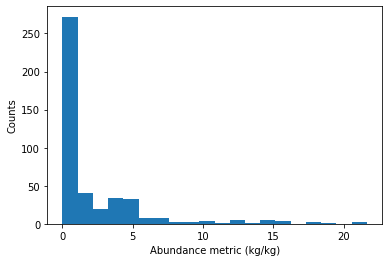

In [34]:
import matplotlib.pyplot as plt

number_of_bins = 20
plt.hist(sorted_values, number_of_bins)
plt.ylabel('Counts')
plt.xlabel(sort_key)
plt.show()